In [1]:
# import modules
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt

# escolha o conjunto de imagens
path = '../../../images/virtual/'
images = glob(path + '10x7/opengl3/*.jpg')

In [2]:
counter = 0
image_set = []

i = np.random.choice(np.arange(0,49),10, replace=False)

for idx in i:

    image_set.append(images[idx])

In [3]:
len(image_set)

10

In [4]:
# Reconstrução do tabuleiro
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize # Square size não interfere na calibração -> somente um fator de escala
                       # o square size não é utilizado na calibração dos cara de stanford
    return X

# Detectando os corners
def detectCorners(images, boardPoints, patternSize):
    worldPoints = []
    imagePoints = [] 

    img_size = 0
    counter = 0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCornersSB(gray, patternSize, None)
        if ret == True:
            #print("Corners found in image " + str(fname)) #- see if corners are found 
            #corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            worldPoints.append(boardPoints)
            imagePoints.append(corners)
            counter+=1

    print("Corners found in " + str(counter) + " images")
    #print(img_size)
    return worldPoints, imagePoints, img_size

# Calibrando a camera
def calibrate(images, useFisheye, patternSize, squareSize, details = True):

    boardPoints = construct3DPoints(patternSize, squareSize)

    worldPoints, imagePoints, imgSize = detectCorners(images, boardPoints, patternSize)

    if useFisheye:
        flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
        calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)

        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                                    flags=flagsCalib,criteria=calibrateCriteria)
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL

        ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(worldPoints, imagePoints, imgSize, None, None,
                                                                flags=flagsCalib)
    if details:
        print("RMS re-projection error:", ret)
        print("The median re-projection error", np.median(perViewError))
        print("Camera Matrix:\n", cameraMatrix)
        print("Distortion Parameters:\n", k)

    return cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError, worldPoints, imagePoints

# calcular erro médio de reprojeção
def calculate_mean_error(image_set, pattern_size, square_size, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []
    
    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)
    board_points = board_points.astype('float32')
    
    # Calculate image points in each image
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, detected_image_points = cv2.findChessboardCornersSB(gray, pattern_size, None)
        
        # If it was detected
        if ret == True: 

            # Calculate extrinsic parameters 
            _, rvec, tvec = cv2.solvePnP(board_points, detected_image_points, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            projected_image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(detected_image_points, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
            
            errors.append(error)
            
            if per_view_error:
                print(f"Mean Error of Image {image}:", error, "px")
    
    mean_error = np.median(errors)
    
    print("Median error: ", mean_error)
    
    return mean_error

# calcular erro rms de reprojeção
def calculate_rms_error(image_set, pattern_size, square_size, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []

    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)

    # Calculate the detected image points
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, corners = cv2.findChessboardCornersSB(gray, pattern_size, None)

        # If it was detected
        if ret == True:
            
            # Calculate extrinsic parameters
            _, rvec, tvec = cv2.solvePnP(board_points, corners, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(corners, image_points, normType= cv2.NORM_L2) / sqrt(len(image_points))
            errors.append(error)
            if per_view_error:
                print(f"RMS Error of Image {image}:", error, "px")

    rms_error = np.median(errors)

    print("Median RMS error: ", rms_error)

    return rms_error

Calibração Inicial - Detectar Outliers

In [5]:
# Calibração Inicial 
camera_matrix, distortion, rotation, translation, stdInt, stdExt, perViewError, world_points, image_points = calibrate(image_set, useFisheye = False, patternSize = (9,7), squareSize = 30)

perViewError = perViewError.flatten()

Corners found in 10 images
RMS re-projection error: 0.32237734631218845
The median re-projection error 0.33356785223037855
Camera Matrix:
 [[631.34334023   0.         359.81378893]
 [  0.         631.23420855 363.40846497]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[ 1.76986060e+01 -2.12533625e+02  6.52047462e-04 -3.59887631e-05
   4.05172195e+02  1.76750937e+01 -2.12344663e+02  4.04912198e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [17]:
print(rotation)

(array([[-0.54396469],
       [-0.00990491],
       [ 3.09236388]]), array([[ 0.00438032],
       [ 0.2690731 ],
       [-3.12953082]]), array([[-8.86667969e-05],
       [ 1.04111010e-02],
       [-3.14149398e+00]]), array([[ 6.91506928e-04],
       [-2.89506591e-01],
       [ 3.12856224e+00]]), array([[-0.00826428],
       [ 0.00777547],
       [-3.14131794]]), array([[-1.39011363e-03],
       [-7.30359834e-03],
       [ 3.14155887e+00]]), array([[ 1.42203328e-03],
       [-2.64041186e-01],
       [-3.13044359e+00]]), array([[0.0041082 ],
       [0.27303284],
       [3.12955273]]), array([[ 1.15143083e-04],
       [-2.76531571e-01],
       [-3.12932422e+00]]), array([[-0.55495701],
       [-0.01204879],
       [ 3.09108648]]))


In [6]:
image_points[0]

array([[[447.53796, 458.84515]],

       [[416.52878, 460.75684]],

       [[383.41614, 462.83524]],

       [[350.5105 , 464.84158]],

       [[315.48303, 467.026  ]],

       [[278.57718, 469.1537 ]],

       [[241.45834, 471.67514]],

       [[201.56987, 474.05716]],

       [[160.5121 , 476.6648 ]],

       [[447.58197, 424.49924]],

       [[416.5634 , 425.90063]],

       [[383.4438 , 427.12415]],

       [[350.52182, 428.54205]],

       [[315.49713, 430.0249 ]],

       [[278.59335, 431.47614]],

       [[241.48332, 433.0483 ]],

       [[201.55406, 434.68414]],

       [[160.56561, 436.26645]],

       [[447.55185, 390.4618 ]],

       [[416.569  , 390.8821 ]],

       [[383.44717, 391.5256 ]],

       [[350.52475, 392.46484]],

       [[315.49316, 392.99823]],

       [[278.5566 , 393.50247]],

       [[240.74628, 394.56992]],

       [[201.54825, 395.43726]],

       [[160.54291, 396.1068 ]],

       [[447.562  , 356.5044 ]],

       [[416.55432, 356.50888]],

       [[383.4

In [7]:
rms_error =  np.median(perViewError)

In [8]:
perViewError.std()

0.051824567118110586

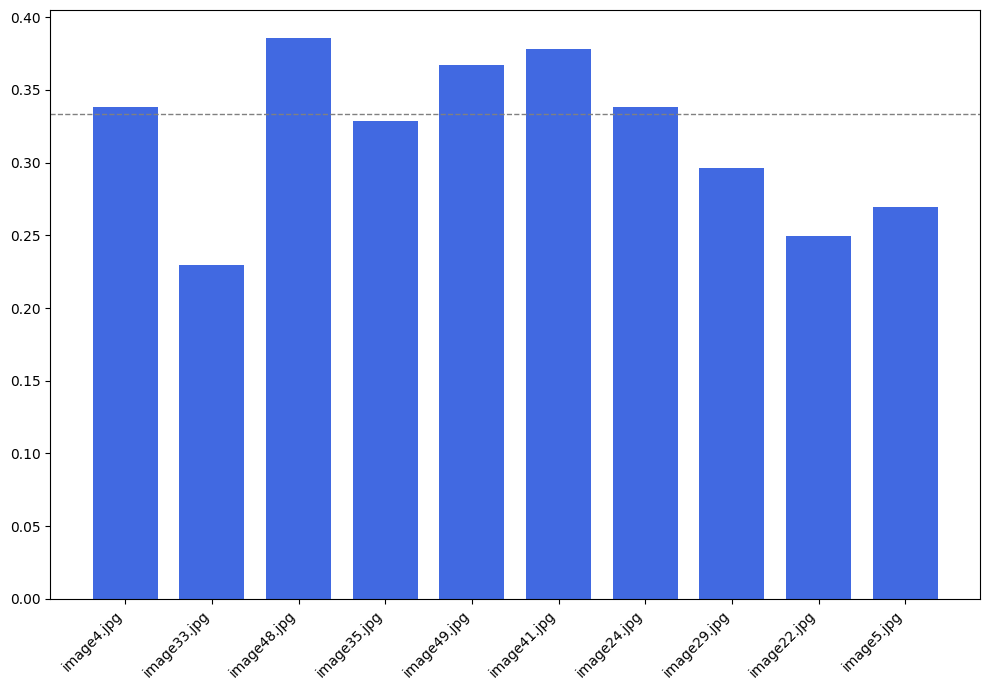

In [9]:
import os

image_files = []
for image in image_set:
    nome_arquivo = os.path.basename(image)
    image_files.append(nome_arquivo)


plt.figure(figsize=(10,7))
plt.bar(image_files, perViewError, color = 'royalblue', width=.75)

plt.axhline(y=rms_error, color='gray', linestyle='--', linewidth=1, label=f'Média: {rms_error:.2f}')

plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das imagens para melhor visualização
plt.tight_layout()  # Ajusta o layout para se encaixar bem na figura
plt.show()

In [10]:
perViewError

array([0.33843902, 0.22952682, 0.38571396, 0.32869668, 0.36691414,
       0.37815204, 0.33853408, 0.29663151, 0.24943555, 0.26980107])

In [11]:
def remove_images(limiar, error, images):
    new_set = []

    for idx, image in enumerate(images):

        if perViewError[idx] > (limiar + error.std()):
            new_set.append(image)

    return new_set

In [12]:
new_set = remove_images(limiar=rms_error, error = perViewError, images= image_set)

for image in new_set:
    image_set.remove(image)

image_set

['../../../images/virtual/10x7/opengl3\\image4.jpg',
 '../../../images/virtual/10x7/opengl3\\image33.jpg',
 '../../../images/virtual/10x7/opengl3\\image35.jpg',
 '../../../images/virtual/10x7/opengl3\\image49.jpg',
 '../../../images/virtual/10x7/opengl3\\image41.jpg',
 '../../../images/virtual/10x7/opengl3\\image24.jpg',
 '../../../images/virtual/10x7/opengl3\\image29.jpg',
 '../../../images/virtual/10x7/opengl3\\image22.jpg',
 '../../../images/virtual/10x7/opengl3\\image5.jpg']

In [13]:
len(image_set)

9

Calibração final - Divisão em Treino e teste

In [14]:
zeros = np.zeros(len(image_set))

images_train, images_test, _, _ = train_test_split(image_set, zeros, test_size=0.3) 

camera_matrix, distortion, rotation, translation, stdInt, stdExt, perViewError = calibrate(images_train, useFisheye = False, patternSize = (9,7), squareSize = 30)

error = calculate_rms_error(image_set=images_test, pattern_size=(9,7), square_size= 30, camera_matrix=camera_matrix, distortion=distortion)

Corners found in 6 images
RMS re-projection error: 0.31276099229662396
The median re-projection error 0.32563987649217085
Camera Matrix:
 [[635.66842905   0.         360.48833116]
 [  0.         635.33219858 364.26799459]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[ 9.63195822e+01  4.15211280e+02  3.17891691e-04 -7.58553965e-05
   1.63910318e+02  9.61486570e+01  4.15374104e+02  1.61629701e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


ValueError: too many values to unpack (expected 7)

Etapa K-fold Cross Validation - Encontrar indicadores de estabilidade


In [ ]:
from math import sqrt

def extract_camera_parameters(camera_matrix, distortion):
    
    fx,fy = camera_matrix[0][0], camera_matrix[1][1]
    cx,cy = camera_matrix[0][2], camera_matrix[1][2]

    camera_parameters = [fx,fy,cx,cy]

    for i in range(8):
        camera_parameters.append(distortion[0][i])

    return camera_parameters

def cross_validation_camera (image_set, K = 10):

    zeros = np.zeros(len(image_set))

    errors_train = []
    errors_test = []
    camera_parameters = []

    for i in range (K):
    
        images_train, images_test, _, _ = train_test_split(image_set, zeros, test_size=0.3)
        
        k_camera_matrix, k_distortion, _, _, _, _, _ = calibrate(images_train, useFisheye = False, patternSize = (9,7), squareSize = 30, details=False)

        error_train = calculate_rms_error(image_set=images_train, pattern_size=(9,7), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_train.append(error_train)

        error_test = calculate_rms_error(image_set=images_test, pattern_size=(9,7), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_test.append(error_test)

        k_camera_parameters = extract_camera_parameters(k_camera_matrix, k_distortion)
        camera_parameters.append(k_camera_parameters)

        print('\n')

    # Calcular Sigma E e Delta E

    print("Var E_train: ", np.var(errors_train, ddof=1))
    print("Var E_test: ", np.var(errors_test,ddof=1))

    print("Delta^2 E_KF: ", sqrt((np.var(errors_train, ddof=1) + np.var(errors_test, ddof=1))))
    
    return camera_parameters     


In [ ]:
def cross_validation (images,K = 5):
    indices  = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]

    fold_size = len(images) // K
    
    errors_train = []
    errors_test = []
    camera_parameters = []

    for i in range(K):

        # Determinar os índices para o conjunto de validação
        start = i * fold_size
        end = start + fold_size if i != K - 1 else len(images)
        
        images_test = images[start:end]
        
        # Determinar os índices para o conjunto de treinamento
        images_train = np.concatenate([images[:start], images[end:]], axis=0)

        k_camera_matrix, k_distortion, _, _, stdInt, stdExt, k_perViewError = calibrate(images_train, useFisheye = False, patternSize = (10,7), squareSize = 30, details=False)

        error_train = calculate_rms_error(image_set=images_train, pattern_size=(10,7), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_train.append(error_train)

        error_test = calculate_rms_error(image_set=images_test, pattern_size=(10,7), square_size= 30, camera_matrix=k_camera_matrix, distortion=k_distortion)
        errors_test.append(error_test)

        k_camera_parameters = extract_camera_parameters(k_camera_matrix, k_distortion)
        camera_parameters.append(k_camera_parameters)

        print('\n')

    # Calcular Sigma E e Delta E

    print("Var E_train: ", np.var(errors_train, ddof=1))
    print("Var E_test: ", np.var(errors_test,ddof=1))

    print("Delta^2 E_KF: ", (np.var(errors_train, ddof=1) + np.var(errors_test, ddof=1)))
    print("")
    return 

In [ ]:
images_train = np.array(images_train)

params = cross_validation_camera(image_set = images_train, K = 10)

Corners found in 18 images
Median RMS error:  0.28744789141248717
Median RMS error:  0.33460514000091


Corners found in 18 images
Median RMS error:  0.3030681510530917
Median RMS error:  0.3251339753326704


Corners found in 18 images
Median RMS error:  0.2851818988108722
Median RMS error:  0.33407885277176197


Corners found in 18 images
Median RMS error:  0.30423994106907526
Median RMS error:  0.31653817347512847


Corners found in 18 images
Median RMS error:  0.2855196990347475
Median RMS error:  0.3264408937807628


Corners found in 18 images
Median RMS error:  0.3166149941326204
Median RMS error:  0.28087664198991014


Corners found in 18 images
Median RMS error:  0.2878856905622812
Median RMS error:  0.33341144523982724


Corners found in 18 images
Median RMS error:  0.3110684648964399
Median RMS error:  0.2887952978812829


Corners found in 18 images
Median RMS error:  0.318985938577575
Median RMS error:  0.28401895864380966


Corners found in 18 images
Median RMS error:  0.315

In [ ]:
params

[[621.2892127034947,
  620.5347160448713,
  358.7125775083492,
  361.12259479227646,
  40.57147616639503,
  18.894335272086252,
  0.0013225053882556929,
  -0.0007920654472832773,
  -279.816258606809,
  40.46317231861413,
  19.352026269923027,
  -280.29133454059297],
 [621.8792208064797,
  621.3191811236591,
  356.9180032916402,
  362.28228440251576,
  74.46726394652455,
  -85.64255525182912,
  0.0013923801646931028,
  -0.0012672374101358728,
  -196.92765802760414,
  74.39740155916421,
  -85.51592347661482,
  -196.83186924124837],
 [619.3192720444182,
  618.8175450488758,
  357.4773562852294,
  361.1057946261412,
  25.973155981995486,
  -18.743012708695495,
  0.0005719659348925881,
  -0.0009097427878917761,
  -108.5634181962083,
  25.92797989539031,
  -18.663383168660815,
  -108.50204848048425],
 [616.8322849406064,
  616.6948782551359,
  356.56566418045304,
  363.0422337457338,
  -40.58407039012797,
  371.20220943924204,
  0.0007732606416236244,
  -0.0010475805408172185,
  1465.5680778

In [ ]:
params = np.array(params)
cov = np.cov(params, rowvar=False)

cov

array([[ 2.91143803e+00,  2.72930602e+00,  6.55768481e-01,
        -5.67793142e-01,  3.20686902e+01, -1.35414570e+02,
         2.01531069e-04, -3.11860602e-06, -3.06372426e+02,
         3.20407964e+01, -1.35522665e+02, -3.05260239e+02],
       [ 2.72930602e+00,  2.60345933e+00,  6.02921954e-01,
        -6.15950228e-01,  2.53226393e+01, -7.47010149e+01,
         9.53661785e-05,  6.45324204e-06, -1.82347965e+02,
         2.52991519e+01, -7.48246439e+01, -1.81788617e+02],
       [ 6.55768481e-01,  6.02921954e-01,  4.18799654e-01,
        -4.51313798e-01, -5.63115975e+00,  3.19467292e+01,
        -2.08619825e-05,  8.68574932e-05,  1.67963574e+00,
        -5.62617674e+00,  3.19297352e+01,  1.43237081e+00],
       [-5.67793142e-01, -6.15950228e-01, -4.51313798e-01,
         1.06631512e+00,  2.11071302e+01, -2.01257795e+02,
         3.65488018e-04, -1.70612775e-04, -1.60936815e+02,
         2.10760295e+01, -2.01137502e+02, -1.59351764e+02],
       [ 3.20686902e+01,  2.53226393e+01, -5.6311597